# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

/Users/berkealtiparmak/.local/share/mamba/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Investigation

In [2]:
# Load connections data (filtered) with columns: pre_root_id, post_root_id, syn_count, etc.
connections = pd.read_csv('data/all/connections.csv')

# Load cell size measurements; expected columns: root_id, length_nm, area_nm, size_nm
cell_size = pd.read_csv('data/all/cell_stats.csv')

# Load classification annotations; expected columns: root_id, label
labels_df = pd.read_csv('data/all/classification.csv')

## Investigating Connections

Head of the Connections dataset:
          pre_root_id        post_root_id neuropil  syn_count nt_type
0  720575940629970489  720575940631267655   AVLP_R          7    GABA
1  720575940605876866  720575940606514878    LAL_R         15    GABA
2  720575940627737365  720575940628914436     AL_L         32     ACH
3  720575940633587552  720575940626452879    SMP_R         15     ACH
4  720575940616871878  720575940621203973   AVLP_L         13    GABA

Shape of connections dataset: (3869878, 5)
Unique pre_root_id count: 129351
Unique post_root_id count: 125192

Synapse Count Statistics:
count    3.869878e+06
mean     8.825489e+00
std      1.300126e+01
min      1.000000e+00
25%      4.000000e+00
50%      6.000000e+00
75%      1.000000e+01
max      2.405000e+03
Name: syn_count, dtype: float64


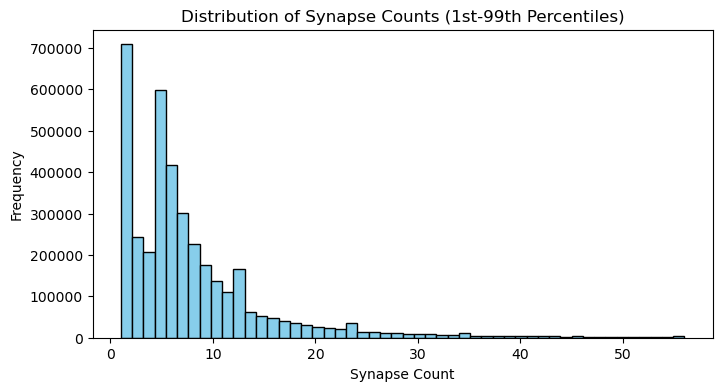

In [3]:
print("Head of the Connections dataset:")
print(connections.head())

print("\nShape of connections dataset:", connections.shape)
print("Unique pre_root_id count:", connections['pre_root_id'].nunique())
print("Unique post_root_id count:", connections['post_root_id'].nunique())
print("\nSynapse Count Statistics:")
print(connections['syn_count'].describe())

# Compute the 1st and 99th percentiles for 'syn_count'
q_low = connections['syn_count'].quantile(0.01)
q_high = connections['syn_count'].quantile(0.99)

# Filter out outliers
filtered_syn_counts = connections['syn_count'][(connections['syn_count'] >= q_low) & (connections['syn_count'] <= q_high)]

# Plot the histogram without outliers
plt.figure(figsize=(8, 4))
plt.hist(filtered_syn_counts, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Synapse Counts (1st-99th Percentiles)")
plt.xlabel("Synapse Count")
plt.ylabel("Frequency")
plt.show()

Here, excluded some outliers as there are some extreme instances, such as a case with a synapse count of 2405! Without excluding such instances, the graph ceases to remain interpretable.

## Investigating Cell Sizes

Head of the Cell Size dataset:
              root_id  length_nm     area_nm       size_nm
0  720575940596125868     396840   628299136   37616302080
1  720575940597856265    1184013  1634424448  100004290560
2  720575940597944841     784742  1022307072   58954229760
3  720575940598267657    1645960  2346787840  140744601600
4  720575940599333574     575383  1366784768  111170764800

Shape of cell size dataset: (139246, 4)

Length (nm) Statistics:
count    1.392460e+05
mean     1.071596e+06
std      1.738372e+06
min      4.930000e+03
25%      3.890615e+05
50%      6.125170e+05
75%      1.123870e+06
max      1.037336e+08
Name: length_nm, dtype: float64

Area (nm) Statistics:
count    1.392460e+05
mean     1.990228e+09
std      3.296213e+09
min      1.514189e+07
25%      7.147744e+08
50%      1.142385e+09
75%      2.054552e+09
max      2.581138e+11
Name: area_nm, dtype: float64

Volume/Size (nm) Statistics:
count    1.392460e+05
mean     1.400852e+11
std      2.485215e+11
min      4.27591

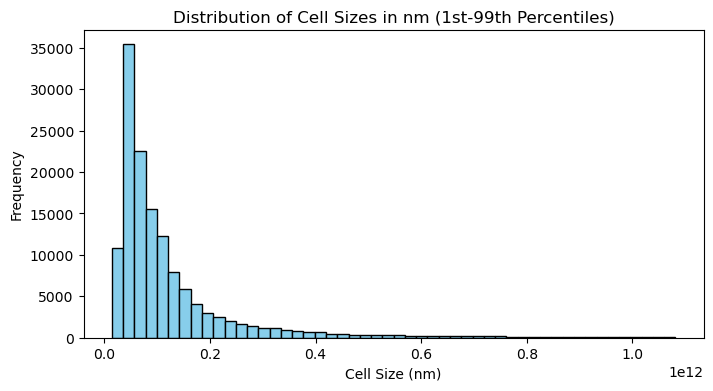

In [4]:
print("Head of the Cell Size dataset:")
print(cell_size.head())

print("\nShape of cell size dataset:", cell_size.shape)
print("\nLength (nm) Statistics:")
print(cell_size['length_nm'].describe())
print("\nArea (nm) Statistics:")
print(cell_size['area_nm'].describe())
print("\nVolume/Size (nm) Statistics:")
print(cell_size['size_nm'].describe())

# Compute the 1st and 99th percentiles for 'size_nm'
data = cell_size['size_nm']
q_low = data.quantile(0.01)
q_high = data.quantile(0.99)

# Filter out outliers
filtered_data = data[(data >= q_low) & (data <= q_high)]

# Plot the histogram without outliers
plt.figure(figsize=(8, 4))
plt.hist(filtered_data, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Cell Sizes in nm (1st-99th Percentiles)")
plt.xlabel("Cell Size (nm)")
plt.ylabel("Frequency")
plt.show()

## Investigating Classifications

Head of the Classification dataset:
              root_id       flow super_class        class sub_class cell_type  \
0  720575940640144768  intrinsic       optic          NaN      L1-5        L1   
1  720575940630759755  intrinsic     central          NaN       NaN    CB1092   
2  720575940637932009  intrinsic     central  Kenyon_Cell       NaN       NaN   
3  720575940606131116  intrinsic       optic          NaN       NaN      Tlp4   
4  720575940633723091  intrinsic       optic          NaN       NaN       Tm4   

  hemibrain_type hemilineage   side nerve  
0            NaN         NaN  right   NaN  
1            NaN         LB3   left   NaN  
2          KCg-m        MBp3   left   NaN  
3            NaN         NaN   left   NaN  
4            NaN         NaN   left   NaN  

Shape of classification dataset: (139255, 10)
Unique class count: 27

Class Distribution:
class
visual                  11391
Kenyon_Cell              5177
CX                       2869
mechanosensory           2

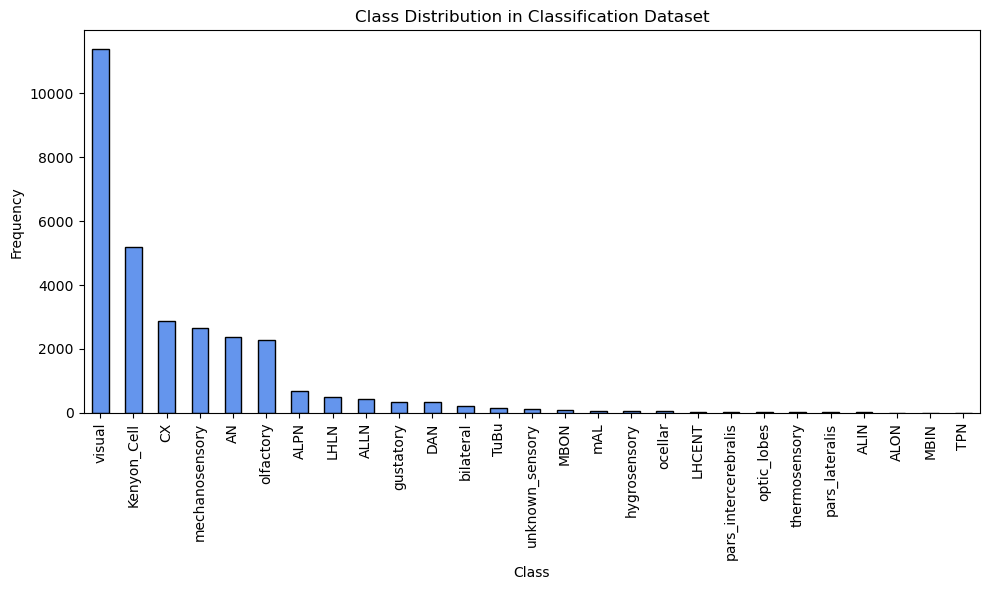

In [5]:
print("Head of the Classification dataset:")
print(labels_df.head())

print("\nShape of classification dataset:", labels_df.shape)
print("Unique class count:", labels_df['class'].nunique())
print("\nClass Distribution:")
print(labels_df['class'].value_counts())

# Plot the class distribution as a bar chart
plt.figure(figsize=(10, 6))
labels_df['class'].value_counts().plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title("Class Distribution in Classification Dataset")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Preprocessing Data

## Constructing Node Features

### Connectivity

In [6]:
# Create a mapping from root_id to a unique index
node_ids = pd.concat([connections['pre_root_id'], connections['post_root_id']]).unique()
node2idx = {node: i for i, node in enumerate(node_ids)}

In [7]:
# For a manageable baseline, we initially select a subset of nodes (e.g., first 5000)
subset_size = 50000
subset_nodes = set(node_ids[:subset_size])

# Filter connections: keep only edges where both nodes are in the subset
connections_sub = connections[
    connections['pre_root_id'].isin(subset_nodes) & connections['post_root_id'].isin(subset_nodes)
]

In [8]:
# Build edge index for PyTorch Geometric: two rows, one for source nodes, one for target nodes
edge_index = torch.tensor([
    [node2idx[node] for node in connections_sub['pre_root_id']],
    [node2idx[node] for node in connections_sub['post_root_id']]
], dtype=torch.long)

print(edge_index)

tensor([[    0,     1,     2,  ..., 39516,   734, 16180],
        [  457, 39683,  4173,  ..., 21634, 43873, 13644]])


### Cell Size

In [9]:
# Create node features from cell size measurements
features = []
for node in node_ids[:subset_size]:
    row = cell_size[cell_size['root_id'] == node]
    if not row.empty:
        # Using cell size features: length, area, and volume (size_nm)
        feat = row[['length_nm', 'area_nm', 'size_nm']].values[0]
    else:
        # If no measurement is available, use zeros
        feat = np.array([0, 0, 0])
    features.append(feat)
x_cell_size = torch.tensor(np.array(features), dtype=torch.float)

print(x_cell_size)

tensor([[3.5835e+06, 7.6436e+09, 6.5386e+11],
        [4.8576e+06, 1.4268e+10, 1.1406e+12],
        [6.9410e+06, 1.3947e+10, 9.5582e+11],
        ...,
        [3.4437e+06, 6.7948e+09, 4.4553e+11],
        [4.8109e+05, 8.7910e+08, 6.5764e+10],
        [7.6938e+05, 1.1479e+09, 6.7137e+10]])


## Consturicting Ground-Truth Labels

### Converting the Labels into Numbers

In [10]:
# Create a label vector for each node using the classification annotations.
# Ensure that each node in node_ids is assigned a label.

# 1. Extract unique classes from the dataset (excluding NaN)
unique_classes = labels_df['super_class'].dropna().unique()

# 2. Create a mapping from class string to integer
class2idx = {cls: i for i, cls in enumerate(unique_classes)}

# 3. Build an integer label vector for each neuron in node_ids
labels = []
for node in node_ids[:subset_size]:
    row = labels_df[labels_df['root_id'] == node]
    if not row.empty:
        cls_value = row['super_class'].values[0]  # The string label, e.g., "visual"
        if pd.notna(cls_value) and cls_value in class2idx:
            label = class2idx[cls_value]   # Map the string label to an int
        else:
            label = -1                     # For unknown or missing classes
    else:
        label = -1                         # If no row found for this neuron
    labels.append(label)

# Convert the label list to a torch tensor of integer IDs
y_int = torch.tensor(labels, dtype=torch.long)

# Create a mask for valid labels (i.e., not -1)
mask = y_int >= 0
reverse_mask = y_int < 0 
print("Integer label tensor:", y_int)
print("Number of missing labels:", reverse_mask.sum().item())

Integer label tensor: tensor([1, 1, 1,  ..., 0, 0, 0])
Number of missing labels: 0


### One-Hot Encoding the Labels

In [11]:
# 4. Convert valid integer labels to one-hot vectors
num_classes = len(class2idx)
y_one_hot = F.one_hot(y_int, num_classes=num_classes).float()
print("One-hot label shape:", y_one_hot.shape)
print("Example one-hot vector:", y_one_hot[0])

One-hot label shape: torch.Size([50000, 9])
Example one-hot vector: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.])


We have 134181 neurons and 9 unique superclasses in total.

### Visualizing the Label Distribution

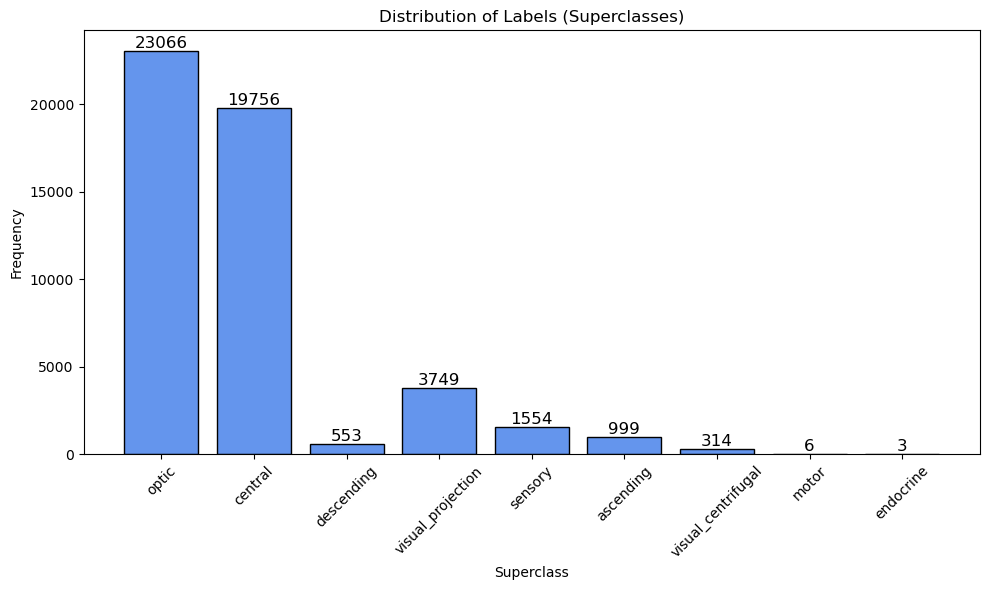

In [12]:
# Get label names back for the valid classes
valid_labels = y_int[mask].numpy()
unique, counts = np.unique(valid_labels, return_counts=True)
idx2class = {v: k for k, v in class2idx.items()}
label_names = [idx2class[i] for i in unique]

# Plot the label distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, counts, color='cornflowerblue', edgecolor='black')
plt.title("Distribution of Labels (Superclasses)")
plt.xlabel("Superclass")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}',
             ha='center', va='bottom', color='black', fontsize=12)

plt.tight_layout()
plt.show()

# Visualizing a (Sub)Graph of our Data

In [13]:
# Convert PyTorch Geometric edge_index to a list of edges
edges = edge_index.t().tolist()

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(len(node_ids)))  # nodes are indexed from 0 to len(node_ids)-1
G.add_edges_from(edges)

/var/folders/pn/y6zh5gpn3rs_kj7p71jpmybh0000gn/T/ipykernel_34684/3449579974.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_valid_classes)


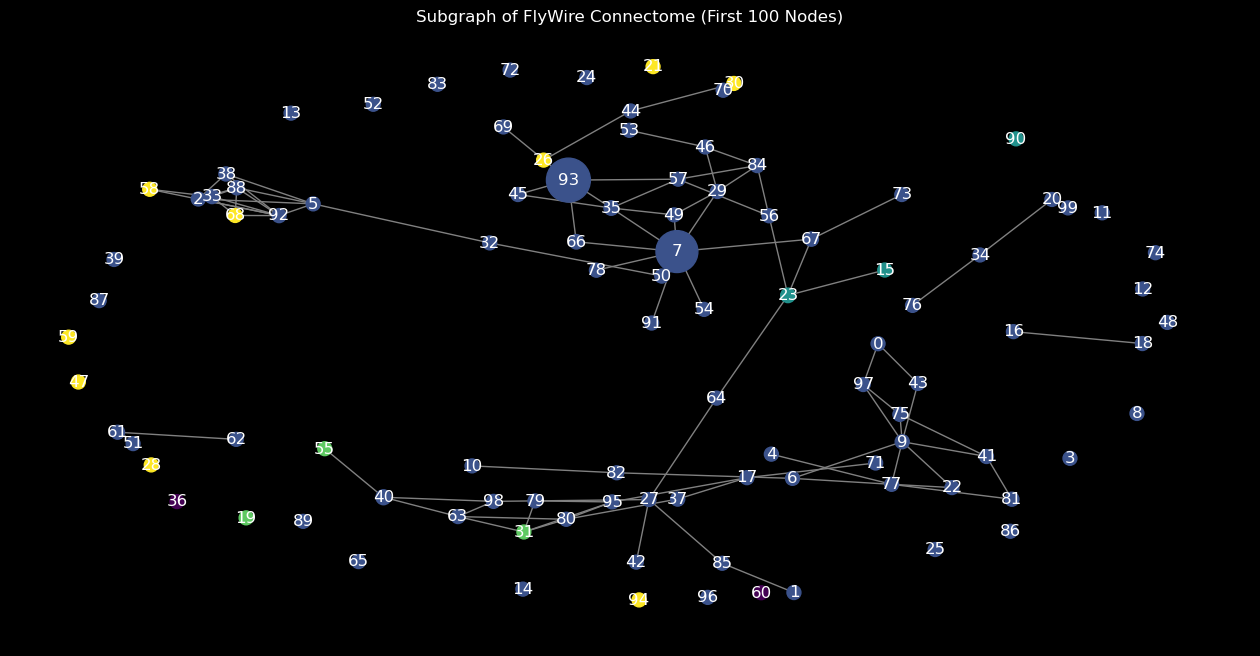

In [14]:
# For visualization, extract a subgraph 
sub_nodes = list(range(100))
subG = nx.Graph()

# Build subgraph from edge_index
# Convert edge_index to list of edges and filter only those edges that connect nodes in sub_nodes
edges = edge_index.t().tolist()
sub_edges = [ (u, v) for u, v in edges if u in sub_nodes and v in sub_nodes ]
subG.add_nodes_from(sub_nodes)
subG.add_edges_from(sub_edges)

# Extract node sizes using the third column ("size_nm") from x for the selected nodes.
sub_features = x_cell_size[sub_nodes].numpy()
# We'll use the third feature as the cell size.
raw_sizes = sub_features[:, 2]

# Normalize sizes to a range that works well for visualization (e.g., between 100 and 1000)
min_size, max_size = raw_sizes.min(), raw_sizes.max()
node_sizes = 100 + 900 * ((raw_sizes - min_size) / (max_size - min_size)) ** 3

# Extract labels for the subgraph nodes from y_int
sub_labels = y_int[sub_nodes].numpy()

# Create a colormap for valid labels. We'll use 'viridis' and assign a default gray for missing labels (-1).
unique_valid_labels = [lbl for lbl in sub_labels if lbl >= 0]
num_valid_classes = len(set(unique_valid_labels)) if unique_valid_labels else 1
cmap = plt.cm.get_cmap('viridis', num_valid_classes)

# Map each node's label to a color.
node_colors = []
for lbl in sub_labels:
    if lbl < 0:
        node_colors.append('#808080')  # gray for missing/invalid labels
    else:
        # Normalize label index to colormap range
        node_colors.append(cmap(lbl % num_valid_classes))

# Generate a layout with increased separation
pos = nx.spring_layout(subG, seed=6, k=0.5, iterations=100)

# Create the plot with a black background
plt.figure(figsize=(16, 8), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

nx.draw_networkx(
    subG, 
    pos=pos, 
    with_labels=True, 
    node_color=node_colors, 
    edge_color='gray', 
    node_size=node_sizes,
    font_color='white'
)

plt.title("Subgraph of FlyWire Connectome (First 100 Nodes)", color='white')
plt.axis('off')
plt.show()

# Forming Datasets

## Constructing the PyTorch Geometric data objects

In [15]:
# We use a constant vector with value 1 for our baseline model
x_plain = torch.ones((subset_size, 1), dtype=torch.float)
print(x_plain)

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])


In [16]:
# We constructed x_cell_size before but we will not use it for our baseline model
print(x_cell_size)

tensor([[3.5835e+06, 7.6436e+09, 6.5386e+11],
        [4.8576e+06, 1.4268e+10, 1.1406e+12],
        [6.9410e+06, 1.3947e+10, 9.5582e+11],
        ...,
        [3.4437e+06, 6.7948e+09, 4.4553e+11],
        [4.8109e+05, 8.7910e+08, 6.5764e+10],
        [7.6938e+05, 1.1479e+09, 6.7137e+10]])


In [17]:
# Create the PyTorch Geometric data object
data_plain = Data(x=x_plain, edge_index=edge_index, y=y_int)

## Train-Test Split

In [18]:
# For training, use only the nodes with valid labels.
valid_idx = torch.nonzero(mask).view(-1)

# Determine number of classes (will be useful when we are defining the models)
num_classes = len(unique_classes)

# Split valid nodes into train and test sets (e.g., 70/30 split)
train_idx_np, test_idx_np = train_test_split(valid_idx.numpy(), test_size=0.3, random_state=6, stratify=y_int[mask].numpy())
train_idx = torch.tensor(train_idx_np, dtype=torch.long)
test_idx = torch.tensor(test_idx_np, dtype=torch.long)

## Inverse Class Weights

In [19]:
# Compute class frequencies from the valid training nodes only
valid_labels = y_int[mask].numpy()
classes, counts = np.unique(valid_labels, return_counts=True)
class_weights = np.zeros(num_classes)
for c, cnt in zip(classes, counts):
    class_weights[c] = 1.0 / cnt  # Inverse frequency

# Convert class weights to a torch tensor and normalize them
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights / class_weights.sum()  # Normalization, though not necessary

print("Class weights:", class_weights)

Class weights: tensor([8.5511e-05, 9.9838e-05, 3.5667e-03, 5.2611e-04, 1.2692e-03, 1.9744e-03,
        6.2815e-03, 3.2873e-01, 6.5746e-01])


# Models

In [30]:
class BaselineGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(BaselineGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.5) # for regularization
        x = self.conv2(x, edge_index)
        return x
baseline_gcn = BaselineGCN(in_channels=data_plain.x.shape[1], hidden_channels=16, num_classes=num_classes)

# Helper Train and Test functions

In [29]:
def get_optimizer(model, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return optimizer

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data, optimizer, criterion):
    # Get the ground truths vs the model predictions
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    y_true = data.y[test_idx].cpu().numpy()
    y_pred = pred[test_idx].cpu().numpy()

    # Compute evaluation metrics: loss, accuracy, f1 score, per class accuracy
    test_loss = criterion(out[test_idx], data.y[test_idx]).item()
    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average='macro')

    # Compute per class accuracy
    test_per_class_acc = []
    for i in range(num_classes):
        idx = np.where(y_true == i)[0]
        if len(idx) > 0:
            acc = np.mean(y_pred[idx] == y_true[idx])
        else:
            acc = np.nan  # No samples for this class in the test set
        test_per_class_acc.append(acc)
    
    return test_loss, test_acc, test_f1, test_per_class_acc

In [22]:
def plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s):  
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    axs[0].plot(epochs_recorded, test_losses, marker='o', color='tab:blue')
    axs[0].set_title("Test Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    
    axs[1].plot(epochs_recorded, test_accuracies, marker='o', color='tab:green')
    axs[1].set_title("Test Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    
    axs[2].plot(epochs_recorded, test_f1s, marker='o', color='tab:red')
    axs[2].set_title("Test F1 Score")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("F1 Score")
    
    plt.tight_layout()
    plt.show()

In [23]:
def plot_experiment_results_per_class(epochs_recorded, per_class_acc_history):  
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(num_classes):
        ax.plot(epochs_recorded, per_class_acc_history[:, i], marker='o', label=f'Class {i}')
    ax.set_title("Per-Category Accuracy over Time")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    plt.show()

# Data Imbalance Techniques

## GraphME

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ME(nn.Module):
    def __init__(self, device, balancing_factor=0.3):
        super(ME, self).__init__()
        self.nll_loss = nn.NLLLoss()
        self.device = device  # Example: 'cuda:0' or 'cpu'
        self.balancing_factor = balancing_factor

    def forward(self, yHat, y, weight=None):
        # yHat is the raw output (logits) from the model.
        # y are the true labels.
        batch_size = len(y)
        
        # Compute the standard cross-entropy loss via negative log likelihood of log_softmax outputs.
        cross_entropy = self.nll_loss(F.log_softmax(yHat, dim=1), y)
        
        # Compute the prediction entropy regularization.
        yHat_soft = F.softmax(yHat, dim=1)
        Px = yHat_soft
        Px_log = torch.log(Px + 1e-10)
        # Sum over samples and classes, then average over the batch
        regularization_entropy = torch.sum(Px * Px_log.to(self.device)) / (float(batch_size) * yHat.shape[1])
        
        # Return the mixed entropy loss: cross_entropy minus balancing_factor * regularization_entropy
        return cross_entropy - self.balancing_factor * regularization_entropy

# Experiments

## Baseline GCN Model, Connectivity Data

Epoch 020: Loss=1.4417, Test Loss=1.4091, Accuracy=0.3951, F1=0.0629
Epoch 040: Loss=1.3312, Test Loss=1.2991, Accuracy=0.5077, F1=0.1203
Epoch 060: Loss=1.2819, Test Loss=1.2615, Accuracy=0.5799, F1=0.1355
Epoch 080: Loss=1.2617, Test Loss=1.2297, Accuracy=0.5892, F1=0.1388
Epoch 100: Loss=1.2406, Test Loss=1.2047, Accuracy=0.5921, F1=0.1403
Epoch 120: Loss=1.2251, Test Loss=1.1865, Accuracy=0.5959, F1=0.1415
Epoch 140: Loss=1.1840, Test Loss=1.1599, Accuracy=0.6020, F1=0.1432
Epoch 160: Loss=1.1510, Test Loss=1.1314, Accuracy=0.6042, F1=0.1440
Epoch 180: Loss=1.1474, Test Loss=1.1073, Accuracy=0.6125, F1=0.1458
Epoch 200: Loss=1.1387, Test Loss=1.0892, Accuracy=0.6197, F1=0.1474
Epoch 220: Loss=1.1011, Test Loss=1.0759, Accuracy=0.6245, F1=0.1483
Epoch 240: Loss=1.0740, Test Loss=1.0682, Accuracy=0.6260, F1=0.1490
Epoch 260: Loss=1.0961, Test Loss=1.0595, Accuracy=0.6292, F1=0.1495
Epoch 280: Loss=1.0926, Test Loss=1.0539, Accuracy=0.6289, F1=0.1497
Epoch 300: Loss=1.0816, Test Loss=

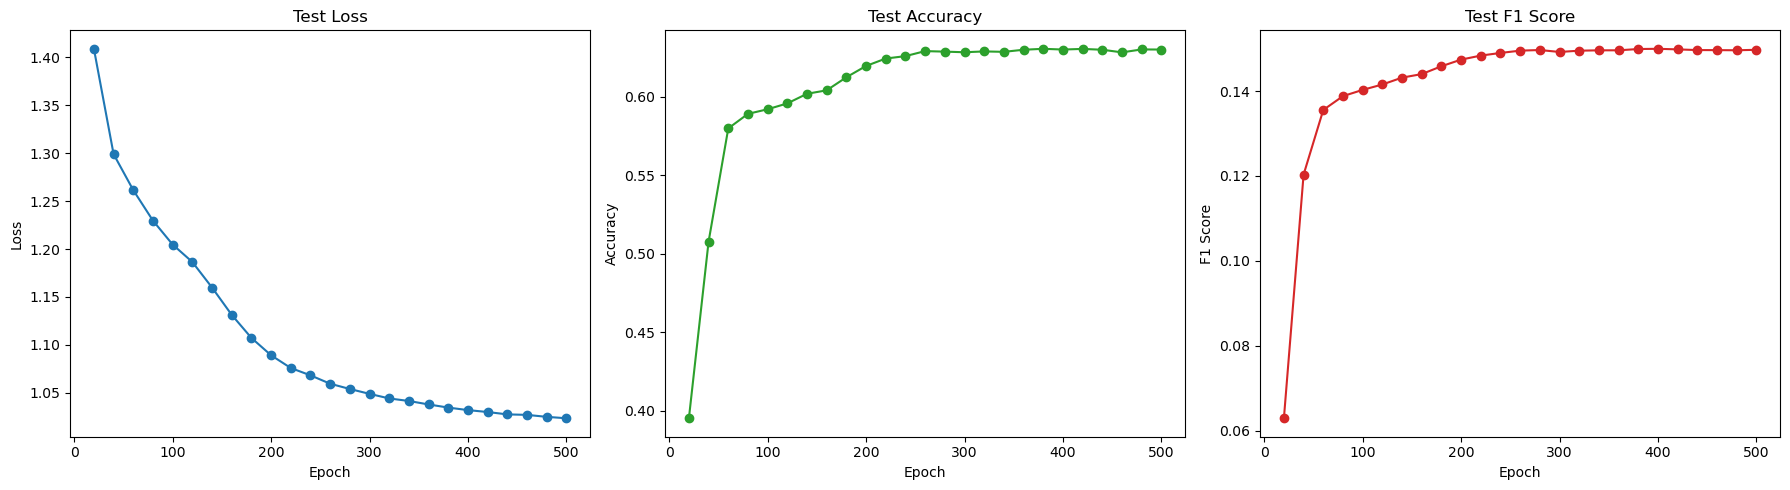

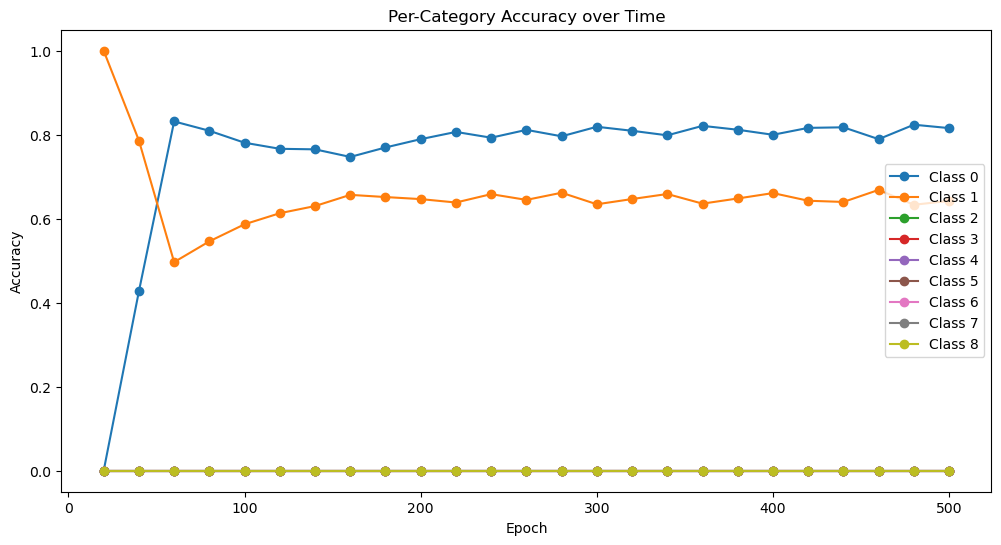

In [31]:
# Setting up the model, data, and the hyperparameters
baseline_gcn = BaselineGCN(in_channels=data_plain.x.shape[1], hidden_channels=16, num_classes=num_classes)
model = baseline_gcn
data = data_plain
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))

## Baseline GCN Model, Connectivity Data, Class Weights

Epoch 020: Loss=2.1267, Test Loss=2.1534, Accuracy=0.0104, F1=0.0044
Epoch 040: Loss=2.0921, Test Loss=2.1191, Accuracy=0.0772, F1=0.0494
Epoch 060: Loss=2.0626, Test Loss=2.0938, Accuracy=0.1131, F1=0.0482
Epoch 080: Loss=2.0150, Test Loss=2.0685, Accuracy=0.1291, F1=0.0748
Epoch 100: Loss=2.0201, Test Loss=2.0339, Accuracy=0.1205, F1=0.0623
Epoch 120: Loss=2.0000, Test Loss=2.0109, Accuracy=0.1493, F1=0.0782
Epoch 140: Loss=1.9683, Test Loss=1.9893, Accuracy=0.1306, F1=0.0813
Epoch 160: Loss=1.9488, Test Loss=1.9709, Accuracy=0.1417, F1=0.0851
Epoch 180: Loss=1.9471, Test Loss=1.9523, Accuracy=0.2360, F1=0.1233
Epoch 200: Loss=1.9116, Test Loss=1.9482, Accuracy=0.3187, F1=0.1436
Epoch 220: Loss=1.9137, Test Loss=1.9306, Accuracy=0.2256, F1=0.1238
Epoch 240: Loss=1.9039, Test Loss=1.9221, Accuracy=0.2660, F1=0.1368
Epoch 260: Loss=1.9198, Test Loss=1.9144, Accuracy=0.2709, F1=0.1426
Epoch 280: Loss=1.8868, Test Loss=1.9117, Accuracy=0.2377, F1=0.1370
Epoch 300: Loss=1.8863, Test Loss=

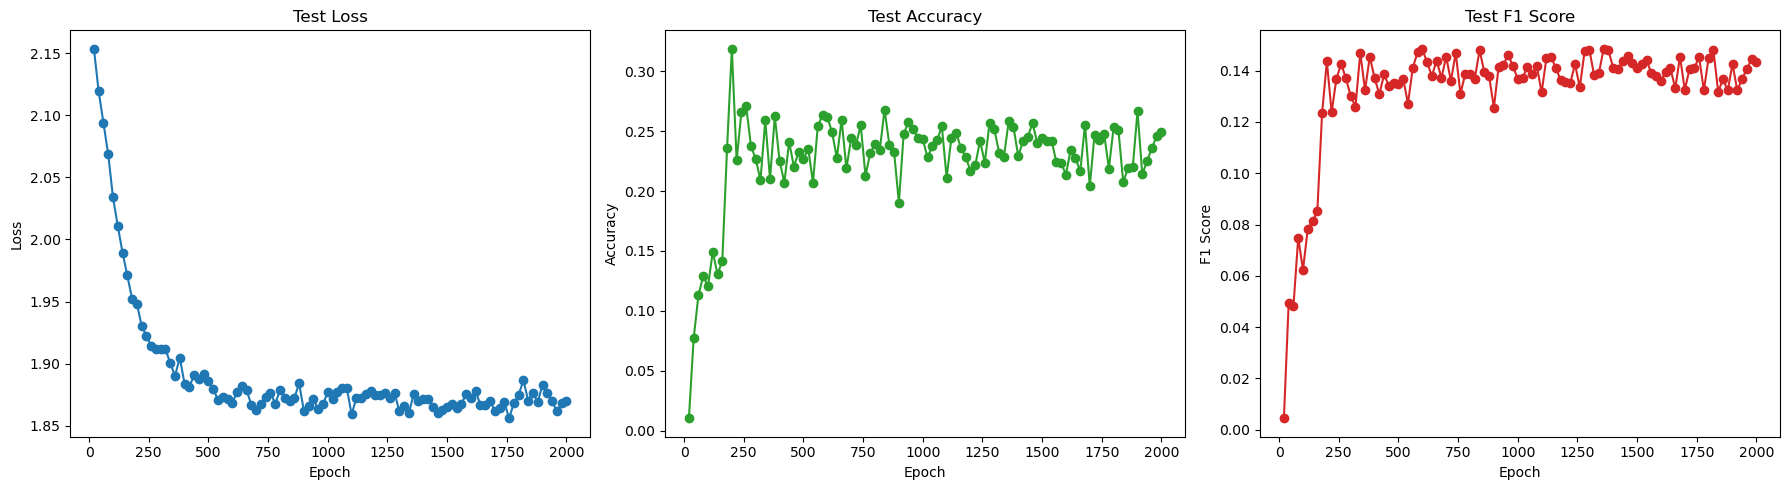

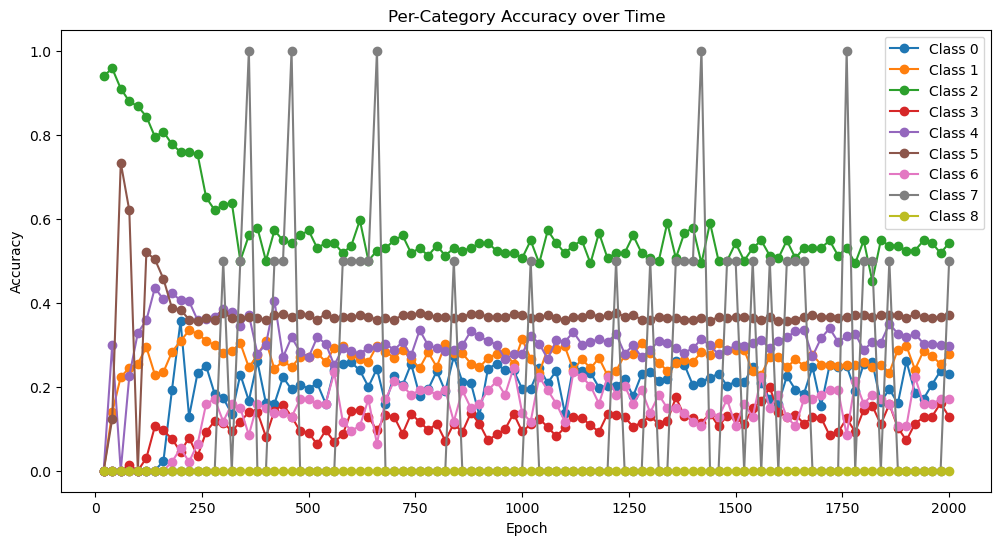

In [35]:
# Setting up the model, data, and the hyperparameters
baseline_gcn = BaselineGCN(in_channels=data_plain.x.shape[1], hidden_channels=16, num_classes=num_classes)
model = baseline_gcn
data = data_plain
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = nn.CrossEntropyLoss(weight=class_weights)
num_epochs = 2000
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))

# Baseline GCN Model, Connectivity Data, ME Loss

Epoch 020: Loss=1.7376, Test Loss=1.6932, Accuracy=0.4613, F1=0.0702
Epoch 040: Loss=1.3886, Test Loss=1.3628, Accuracy=0.3979, F1=0.0665
Epoch 060: Loss=1.3289, Test Loss=1.2999, Accuracy=0.5096, F1=0.1192
Epoch 080: Loss=1.2794, Test Loss=1.2628, Accuracy=0.5825, F1=0.1393
Epoch 100: Loss=1.2366, Test Loss=1.2225, Accuracy=0.5872, F1=0.1403
Epoch 120: Loss=1.2193, Test Loss=1.1948, Accuracy=0.5861, F1=0.1399
Epoch 140: Loss=1.2108, Test Loss=1.1839, Accuracy=0.5873, F1=0.1402
Epoch 160: Loss=1.2022, Test Loss=1.1742, Accuracy=0.5919, F1=0.1409
Epoch 180: Loss=1.1841, Test Loss=1.1682, Accuracy=0.5941, F1=0.1413
Epoch 200: Loss=1.2164, Test Loss=1.1620, Accuracy=0.5946, F1=0.1414
Epoch 220: Loss=1.1657, Test Loss=1.1556, Accuracy=0.5951, F1=0.1411
Epoch 240: Loss=1.1756, Test Loss=1.1516, Accuracy=0.5958, F1=0.1412
Epoch 260: Loss=1.1721, Test Loss=1.1475, Accuracy=0.5979, F1=0.1421
Epoch 280: Loss=1.1630, Test Loss=1.1426, Accuracy=0.5979, F1=0.1418
Epoch 300: Loss=1.1496, Test Loss=

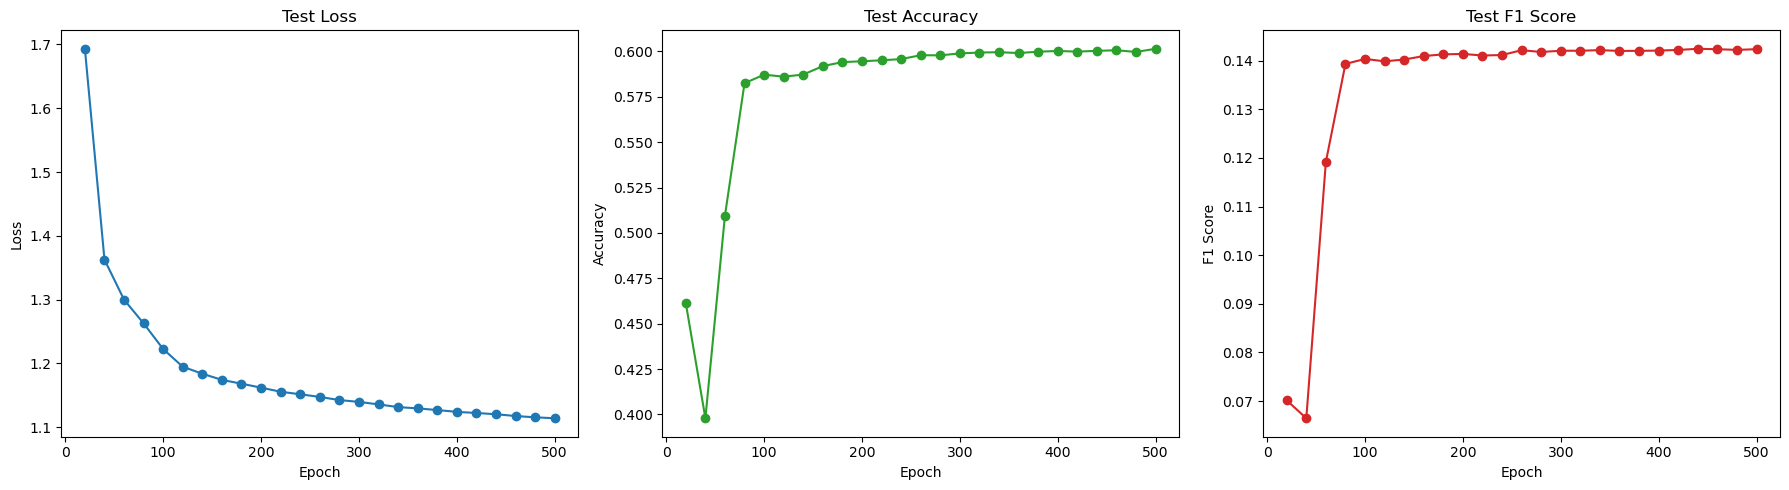

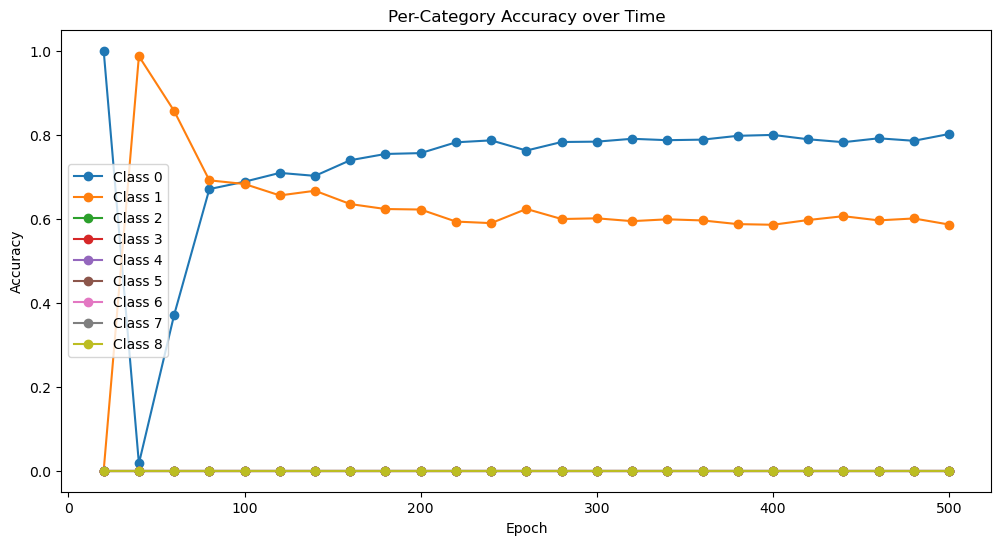

In [42]:
# Setting up the model, data, and the hyperparameters
baseline_gcn = BaselineGCN(in_channels=data_plain.x.shape[1], hidden_channels=16, num_classes=num_classes)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = baseline_gcn.to(device)
data = data_plain.to(device)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = ME(device=device, balancing_factor=0.3)
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))